In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, shutil
sys.path.append('../../../fastai')

# this file contains all the main external libs used
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
DS_PATH = '../../datasets/in-or-out'
PATH = 'data/in-or-out'

In [4]:
arch = resnet34
sz = 224
bsz = 4

## 1. Data preparation

In [ ]:
shutil.rmtree(f'{DS_PATH}/train')
shutil.rmtree(f'{DS_PATH}/test')
shutil.rmtree(f'{DS_PATH}/valid')
shutil.rmtree(f'{DS_PATH}/sample')

CLASSES = [ os.path.basename(d) for d in glob(os.path.join(DS_PATH, '*')) ]

In [ ]:
g = glob(f'{DS_PATH}/*/*')

for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P' and img.format == 'PNG' and not f.endswith('.jpg')):
        img = scipy.misc.imread(f, mode='RGBA')
        img = PIL.Image.fromarray(img)
        img.save(f)


In [ ]:
# remove gif and jpegs with weird transparency settings
g = glob(f'{DS_PATH}/*/*')
for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P'):
        os.remove(f)

### Create train, validation, test, and sample dirs

In [ ]:
for d in CLASSES:
    os.makedirs(f'{DS_PATH}/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/valid/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/valid/{d}', exist_ok=True)
    
os.makedirs(f'{DS_PATH}/sample/test/unknown', exist_ok=True)
os.makedirs(f'{DS_PATH}/test/unknown', exist_ok=True)

### Move training, validation, and test data into appropriate sub-dirs

In [ ]:
# COPY images into /train directory
for d in CLASSES:
    for f in os.listdir(f'{DS_PATH}/{d}'): 
        if (not f.startswith('.')): shutil.copyfile(f'{DS_PATH}/{d}/{f}', f'{DS_PATH}/train/{d}/{f}')

In [ ]:
# MOVE a subset of /train images into /valid
g = glob(f'{DS_PATH}/train/*/*')
n_valid = int(len(g) * 0.2)

shuf = np.random.permutation(g)
for i in range(n_valid): os.rename(shuf[i], shuf[i].replace('train', 'valid'))

### Copy a small subset of training data into /sample dir

In [ ]:
# COPY a small subset of each class into /sample
g = glob(f'{DS_PATH}/train/*/*')

shuf = np.random.permutation(g)
for i in range(100): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/train'))
    
shuf = np.random.permutation(g)
for i in range(50): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/valid'))

## 2. Configure paths

In [ ]:
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

abs_ds_path = os.path.abspath(DS_PATH)

# symlink to root datasets so can use same data in other projects
!ln -s {abs_ds_path}/train {PATH}
!ln -s {abs_ds_path}/valid {PATH}
!ln -s {abs_ds_path}/test {PATH}
!ln -s {abs_ds_path}/sample {PATH}

## 3. Review Data

* TO DO

In [ ]:
g = glob(f'{PATH}/train/*/*')
size_d = {f: PIL.Image.open(f).size for f in g}

In [ ]:
row_sz, col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

In [ ]:
row_sz[:5]

In [ ]:
plt.hist(row_sz[row_sz<1000])
plt.show()
plt.hist(col_sz[col_sz<1000])
plt.show()

## 4. Training

**Review: easy steps to train a world-class image classifier:**
1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [5]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}/tmp

In [6]:
# 1. Enable data augmentation, and precompute=True
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=bsz, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

100%|██████████| 116/116 [00:55<00:00,  2.11it/s]


In [7]:
# 2. Use lr_find() to find highest learning rate where loss is still clearly improving
lrf = learn.lr_find()

A Jupyter Widget

 65%|██████▍   | 300/464 [00:05<00:02, 57.93it/s, loss=2.78] 


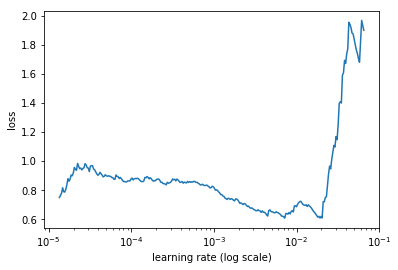

In [8]:
# learn.sched.plot_lr()
# plt.show()
learn.sched.plot()
plt.show()

In [ ]:
# 3. Train last layer from precomputed activations for 1-2 epochs
learn.fit(1e-3, 1)

In [ ]:
learn.lr_find()

In [ ]:
# 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
learn.precompute = False
learn.fit(1e-3, 3, cycle_len=1)

In [ ]:
# 5. Unfreeze all layers
learn.unfreeze()

In [9]:
# 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
lr = np.array([1e-5, 1e-4, 1e-3])

In [10]:
# 7. Use lr_find() again
lrf = learn.lr_find(lr)

A Jupyter Widget

 93%|█████████▎| 432/464 [00:07<00:00, 58.13it/s, loss=2.33] 


In [ ]:
# 8. Train full network with cycle_mult=2 until over-fitting
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)